In [ ]:
!pip install pandas

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# Torch
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
import torch.optim as optim
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.datasets import MNIST
import torch.nn.functional as F
import torch.nn as nn

from math import ceil


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
# Resize the image and do a center crop, and store them on a tensor
import torchvision.transforms as transforms
img_size = (224, 224)
batch_size=32
train_data_dir = '/content/drive/MyDrive/brain/Training'
test_data_dir = '/content/drive/MyDrive/brain/Testing'

#preprocessing : standardizing the sizes
#datsets and dataloaders
transform = transforms.Compose([transforms.Resize(img_size), transforms.ToTensor()])
train_dataset = datasets.ImageFolder(train_data_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_data_dir,transform=transform)

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = False)

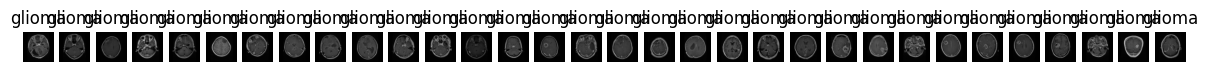

In [7]:
images, labels = next(iter(test_loader))

# Plot the images in a grid
num_images = len(images)
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

for i in range(num_images):
    image = images[i].permute(1, 2, 0).numpy()  # Convert tensor to NumPy array and permute dimensions
    label =test_dataset.classes[labels[i]]     # Get the label corresponding to the index

    axes[i].imshow(image)
    axes[i].set_title(label)
    axes[i].axis('off')

plt.show()

*EffiecientNet Implementation**

In [8]:
base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
}


In [9]:
class CNNBlock(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU()  # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))


class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)


class InvertedResidualBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        expand_ratio,
        reduction=4,  # squeeze excitation
        survival_prob=0.8,  # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels,
                hidden_dim,
                kernel_size=3,
                stride=1,
                padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim,
                hidden_dim,
                kernel_size,
                stride,
                padding,
                groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = (
            torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        )
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)

In [10]:
class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )

    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha**phi
        width_factor = beta**phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4 * ceil(int(channels * width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride=stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size // 2,  # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        x = self.pool(self.features(x))
        return self.classifier(x.view(x.shape[0], -1))


Training Fuction

In [24]:
def train(model, train_loader, test_loader, training_name, saved_weights_dir, epochs, lr):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0

        for batch_number, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            print(f'Epoch {epoch+1}/{epochs}, Batch number: {batch_number}, Cumulated accuracy: {correct/total}')

        epoch_loss /= len(train_loader)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Train loss: {epoch_loss:.4f}, Train accuracy: {epoch_acc:.4f}')

        model.eval()
        epoch_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss /= len(test_loader)
        epoch_acc = correct / total
        test_losses.append(epoch_loss)
        test_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Test loss: {epoch_loss:.4f}, Test accuracy: {epoch_acc:.4f}')
        savedDir = f'{saved_weights_dir}/{training_name}_epoch_{epoch}.pth'
        torch.save(model.state_dict(), savedDir)
        print(f'Saved weights to {savedDir}')

    return train_losses, train_accuracies, test_losses, test_accuracies


In [25]:
def plot_graph(train_acc, test_acc):
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Accuracy')
    plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy vs. Epochs')
    plt.legend()
    plt.show()

In [26]:
def plot_loss_graph(train_loss, test_loss):
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
    plt.plot(range(1, len(test_loss) + 1), test_loss, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Test Loss vs. Epochs')
    plt.legend()
    plt.show()

Model 1: Using b0 variation

In [27]:
model = EfficientNet(version='b0', num_classes=4).to(device)
print(model)
training_name="efficientNet"
saved_weights_dir="/content/drive/MyDrive/EN"
max_epochs=15

EfficientNet(
  (pool): AdaptiveAvgPool2d(output_size=1)
  (features): Sequential(
    (0): CNNBlock(
      (cnn): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (silu): SiLU()
    )
    (1): InvertedResidualBlock(
      (conv): Sequential(
        (0): CNNBlock(
          (cnn): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (silu): SiLU()
        )
        (1): SqueezeExcitation(
          (se): Sequential(
            (0): AdaptiveAvgPool2d(output_size=1)
            (1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (2): SiLU()
            (3): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (4): Sigmoid()
          )
        )
        (2): Conv2d(32, 16, kernel_size=(1, 1), stride=(

In [28]:
train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
                                                                     train_loader, \
                                                                     test_loader, \
                                                                     training_name= training_name,\
                                                                     saved_weights_dir=saved_weights_dir,\
                                                                     epochs = max_epochs, \
                                                                     lr = 1e-3)

Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.34375
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.34375
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.3229166666666667
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.328125
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.325
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.34375
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.33482142857142855
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.34375
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.3506944444444444
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.371875
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.375
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.375
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.375
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.38169642857142855
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.38333333333333336
Epoch 1/15, Batch number: 15, Cumulated accuracy: 0.388671875
Epoch 1/15, Batch number: 

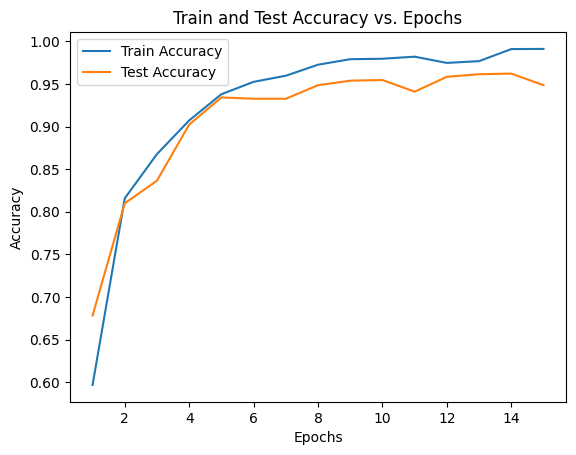

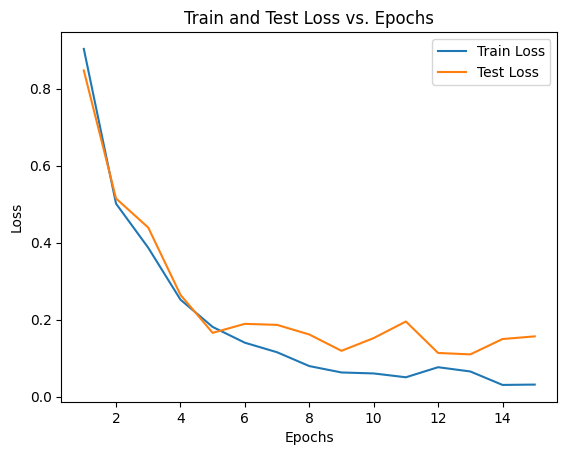

In [29]:
plot_graph(train_accuracies, test_accuracies)
plot_loss_graph(train_losses, test_losses)

**b1 variant** : Model 1

In [31]:
model = EfficientNet(version='b1', num_classes=4).to(device)
print(model)
training_name="efficientNet"
saved_weights_dir="/content/drive/MyDrive/EN/Model1"
max_epochs=15

EfficientNet(
  (pool): AdaptiveAvgPool2d(output_size=1)
  (features): Sequential(
    (0): CNNBlock(
      (cnn): Conv2d(3, 33, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (silu): SiLU()
    )
    (1): InvertedResidualBlock(
      (conv): Sequential(
        (0): CNNBlock(
          (cnn): Conv2d(33, 33, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=33, bias=False)
          (bn): BatchNorm2d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (silu): SiLU()
        )
        (1): SqueezeExcitation(
          (se): Sequential(
            (0): AdaptiveAvgPool2d(output_size=1)
            (1): Conv2d(33, 8, kernel_size=(1, 1), stride=(1, 1))
            (2): SiLU()
            (3): Conv2d(8, 33, kernel_size=(1, 1), stride=(1, 1))
            (4): Sigmoid()
          )
        )
        (2): Conv2d(33, 16, kernel_size=(1, 1), stride=(

In [32]:
train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
                                                                     train_loader, \
                                                                     test_loader, \
                                                                     training_name= training_name,\
                                                                     saved_weights_dir=saved_weights_dir,\
                                                                     epochs = max_epochs, \
                                                                     lr = 1e-3)

Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.1875
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.296875
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.3229166666666667
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.34375
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.325
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.3489583333333333
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.3482142857142857
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.375
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.3784722222222222
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.38125
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.3693181818181818
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.359375
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.3557692307692308
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.36160714285714285
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.35
Epoch 1/15, Batch number: 15, Cumulated accuracy: 0.35546875
Epoch 1

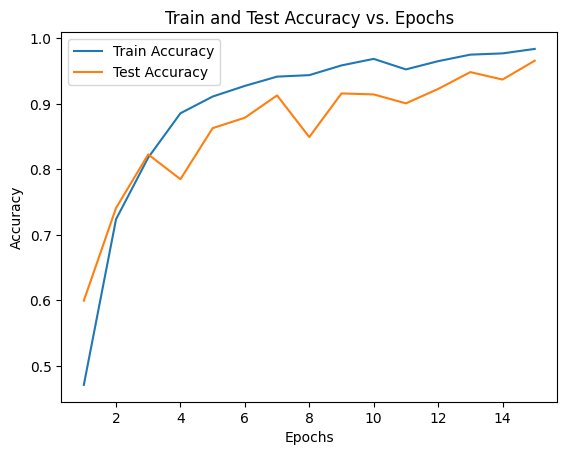

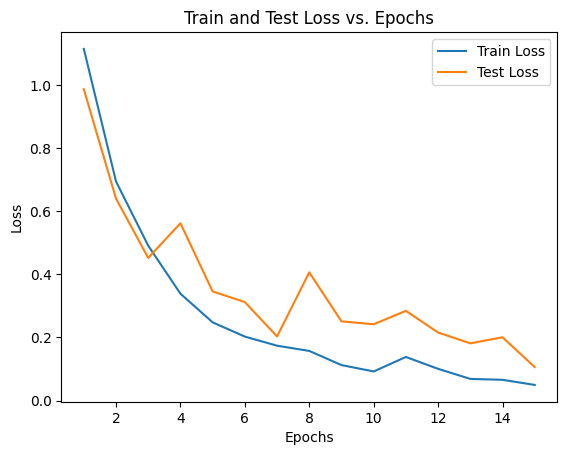

In [34]:
plot_graph(train_accuracies, test_accuracies)
plot_loss_graph(train_losses, test_losses)

In [36]:
model = EfficientNet(version='b2', num_classes=4).to(device)
training_name="efficientNet"
saved_weights_dir="/content/drive/MyDrive/EN/b2"
max_epochs=15

In [37]:
train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
                                                                     train_loader, \
                                                                     test_loader, \
                                                                     training_name= training_name,\
                                                                     saved_weights_dir=saved_weights_dir,\
                                                                     epochs = max_epochs, \
                                                                     lr = 1e-3)

Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.15625
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.28125
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.3229166666666667
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.3203125
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.3125
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.3177083333333333
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.32142857142857145
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.328125
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.3263888888888889
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.3375
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.35511363636363635
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.3645833333333333
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.3581730769230769
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.34375
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.3333333333333333
Epoch 1/15, Batch number: 15, Cumulated accuracy:

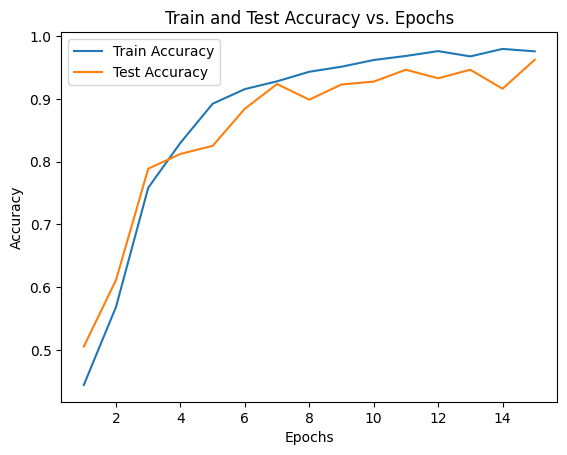

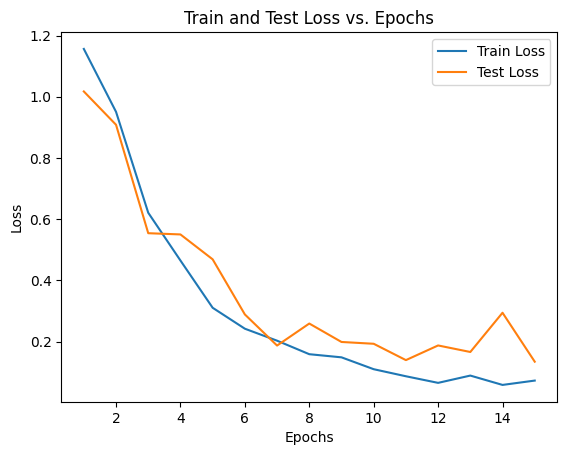

In [38]:
plot_graph(train_accuracies, test_accuracies)
plot_loss_graph(train_losses, test_losses)

**b1 Model 2**

In [40]:
model = EfficientNet(version='b1', num_classes=4).to(device)
print(model)
training_name="efficientNet"
saved_weights_dir="/content/drive/MyDrive/EN/b1/Model2"
max_epochs=15

EfficientNet(
  (pool): AdaptiveAvgPool2d(output_size=1)
  (features): Sequential(
    (0): CNNBlock(
      (cnn): Conv2d(3, 33, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (silu): SiLU()
    )
    (1): InvertedResidualBlock(
      (conv): Sequential(
        (0): CNNBlock(
          (cnn): Conv2d(33, 33, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=33, bias=False)
          (bn): BatchNorm2d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (silu): SiLU()
        )
        (1): SqueezeExcitation(
          (se): Sequential(
            (0): AdaptiveAvgPool2d(output_size=1)
            (1): Conv2d(33, 8, kernel_size=(1, 1), stride=(1, 1))
            (2): SiLU()
            (3): Conv2d(8, 33, kernel_size=(1, 1), stride=(1, 1))
            (4): Sigmoid()
          )
        )
        (2): Conv2d(33, 16, kernel_size=(1, 1), stride=(

In [41]:
train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
                                                                     train_loader, \
                                                                     test_loader, \
                                                                     training_name= training_name,\
                                                                     saved_weights_dir=saved_weights_dir,\
                                                                     epochs = max_epochs, \
                                                                     lr = 1e-4)

Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.34375
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.34375
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.3333333333333333
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.3359375
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.35625
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.375
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.3705357142857143
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.37109375
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.3680555555555556
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.35625
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.3693181818181818
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.3619791666666667
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.3581730769230769
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.3549107142857143
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.36875
Epoch 1/15, Batch number: 15, Cumulated accuracy: 0.36914062

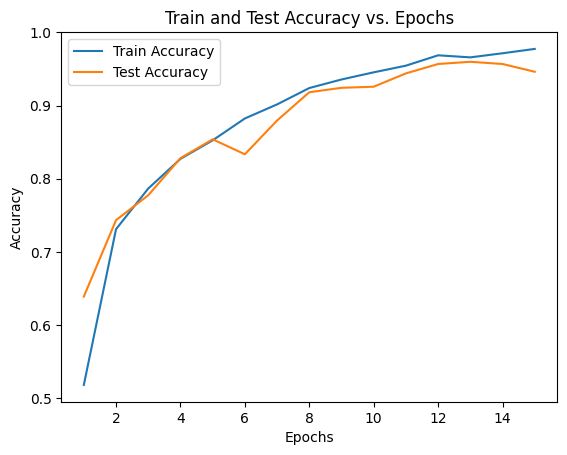

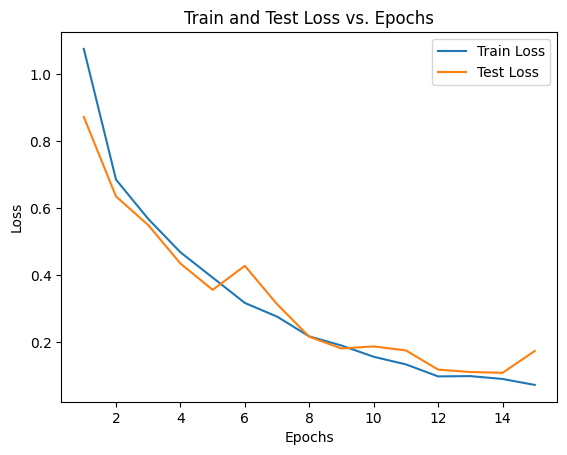

In [42]:
plot_graph(train_accuracies, test_accuracies)
plot_loss_graph(train_losses, test_losses)